In [1]:
import csoundengine as ce

In [2]:
from csoundengine import OfflineEngine
e = OfflineEngine()




--Csound version 6.19 (double samples) Jan 19 2025
[commit: 2536da284dd70ec7272040cb0763f70ae57123c4]
libsndfile-1.2.0
sr = 44100.0, kr = 689.062, ksmps = 64
0dBFS level = 1.0, A4 tuning = 442.0
audio buffered in 256 sample-frame blocks
writing 1024-byte blks of shorts to /tmp/csoundengine-b4t87f5q.wav (WAV)
SECTION 1:


In [3]:
e.compile(r'''
instr pitchtrack
  itabnum = p4   ; the sound source
  itabfreq = p5  ; the table where to put tracked pitch. The table must be big enough
  itabsize = ftlen(itabfreq)
  ifftsize = 2048
  ifftsize2 = ifftsize * 2  ; this second anaylsis helps smooth the result
  iwtype = 0        ; hamming
  kcount init 1     ; the first element is the element count
  aouts[] loscilx 1, 1, itabnum, 4, 1
  a0 = aouts[0]     ; only analyze first channel
  a0d = delay(a0, ifftsize2 * 0.5 / sr)  ; shift the original signal
  fsig  pvsanal a0d, ifftsize, 512, ifftsize, iwtype
  fsig2 pvsanal a0, ifftsize2, 512, ifftsize2, iwtype
  kfreq, kamp pvspitch fsig, 0.03
  kfreq2, kamp2 pvspitch fsig2, 0.01
  if kcount >= itabsize || detectsilence(a0, db(-90), 0.1) == 1 then
    turnoff
  endif
  if (kfreq == 0 && kfreq2 > 0 && kfreq2 < 300) then
      kfreq = kfreq2
  endif
  if (kfreq > 0 && kfreq2 > 0 && kfreq / kfreq2 > 1.25) then
      kfreq = kfreq2
  endif
  tabw kfreq, kcount, itabfreq
  kcount += 1
  tabw kcount, 0, itabfreq
  ; To validate the analysis, we output the original sound and the resynthesized audio
  outs a0d, buzz(lagud(interp(kfreq > 0 ? kamp : 0), 0.02, 0.2), kfreq, 7, -1)
endin
''')

In [4]:
# sndtab = e.readSoundfile("/home/em/Lib/snd/samples/test/piano-pitchtest-2.flac")
sndtab = e.readSoundfile("/home/em/Lib/snd/samples/speech/colours-german-male-1.flac")

sndtabinfo = e.tableInfo(sndtab)
sndtabinfo

TableInfo(sr=44100, size=473758, numChannels=1, path='/home/em/Lib/snd/samples/speech/colours-german-male-1.flac', hasGuard=False)

In [5]:
duration = sndtabinfo.duration
numcycles = int(duration * e.sr / e.ksmps)
freqtab = e.makeEmptyTable(numcycles + 100)
e.sched('pitchtrack', 0, duration + 0.1, sndtab, freqtab)

'pitchtrack'

In [6]:
e.perform()
# Now retrieve information
outarr = e.getTableData(freqtab)
datalen = int(outarr[0])
freqs = outarr[1:1+datalen]
print(freqs)
# Finished with the engine, stop it so that we can access the generated soundfile
# for validation. This is just to show that the output file is only fully formed
# after the engine is stopped
renderjob = e.stop()

# Open the outfile in the default application
# renderjob.openOutfile()


[0. 0. 0. ... 0. 0. 0.]


resetting Csound instance
end of score.		   overall amps:  0.89328  0.60513
	   overall samples out of range:        0        0
0 errors in performance
512 1024 sample blks of shorts written to /tmp/csoundengine-b4t87f5q.wav (WAV)


In [7]:
renderjob.openOutfile(app='ocenaudio')


(ocenaudio:340261): Gtk-WARNING **: 02:18:21.868: Theme parsing error: gtk.css:4:18: Unit is missing.

(ocenaudio:340261): Gtk-WARNING **: 02:18:21.868: Theme parsing error: gtk.css:16:18: Unit is missing.


RenderJob(outfile='/tmp/csoundengine-xnq43v8q.wav', samplerate=44100, encoding='float32', starttime=0.0, endtime=0.0, process=None)
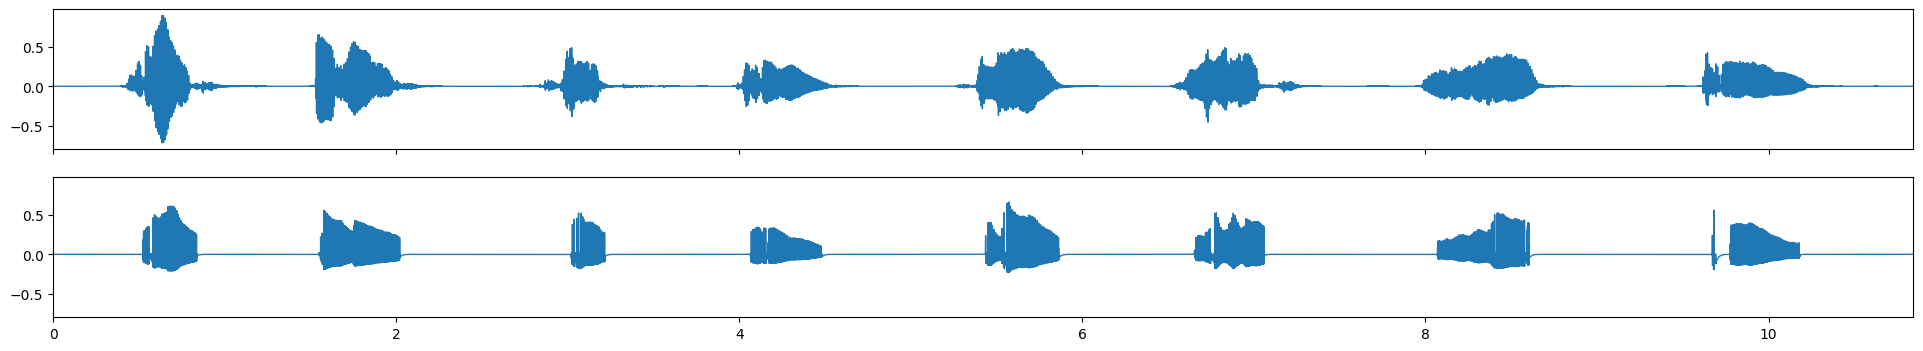

In [8]:
renderjob

In [9]:
renderjob.outfile

'/tmp/csoundengine-nkxyq9u0.wav'